In [1]:
# Import necessary modules

import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
import xarray as xr
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import matplotlib.colors as colors
import geopandas as gpd
from urllib.request import urlretrieve
import requests
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from pathlib import Path
from datetime import datetime, timedelta
import json
import sys
import math
from geopy.distance import distance
from matplotlib.colors import to_rgba
from collections import defaultdict
import glob
from skimage import exposure
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

c:\Users\hanshil\Documents\GitHub\biocarbon_nrt_data_viz\data\satellite\SENTINEL
geo_coordinates.nc
instrument_data.nc
Oa01_radiance.nc
Oa02_radiance.nc
Oa03_radiance.nc
Oa04_radiance.nc
Oa05_radiance.nc
Oa06_radiance.nc
Oa07_radiance.nc
Oa08_radiance.nc
Oa09_radiance.nc
Oa10_radiance.nc
Oa11_radiance.nc
Oa12_radiance.nc
Oa13_radiance.nc
Oa14_radiance.nc
Oa15_radiance.nc
Oa16_radiance.nc
Oa17_radiance.nc
Oa18_radiance.nc
Oa19_radiance.nc
Oa20_radiance.nc
Oa21_radiance.nc
qualityFlags.nc
tie_geometries.nc
tie_geo_coordinates.nc
tie_meteo.nc
time_coordinates.nc
<xarray.Dataset> Size: 2GB
Dimensions:        (rows: 15150, columns: 1217)
Dimensions without coordinates: rows, columns
Data variables: (12/21)
    Oa01_radiance  (rows, columns) float32 74MB dask.array<chunksize=(5050, 406), meta=np.ndarray>
    Oa02_radiance  (rows, columns) float32 74MB dask.array<chunksize=(5050, 406), meta=np.ndarray>
    Oa03_radiance  (rows, columns) float32 74MB dask.array<chunksize=(5050, 406), meta=np.n

C:\Users\hanshil\AppData\Roaming\Python\Python312\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


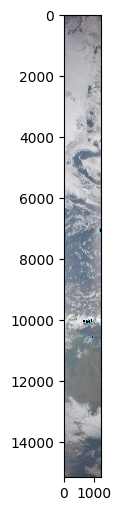

In [23]:
# Establish directory locations

parent_dir    = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir      = os.path.join(parent_dir, 'data')
satellite_dir = os.path.join(data_dir, 'satellite')
output_dir    = os.path.join(parent_dir, 'Output/sat_plot')
NEODASS_dir   = os.path.join(satellite_dir, 'NEODASS')
floats_dir    = os.path.join(parent_dir, 'Data/Floats')
sentinel_dir  = os.path.join(satellite_dir, 'SENTINEL')
sen3_dirs     = [os.path.join(sentinel_dir, d) for d in os.listdir(sentinel_dir) if '.SEN3' in d]

cur_sen_dir = sen3_dirs[7]

matching_files = []
print(sentinel_dir)
for filename in os.listdir(cur_sen_dir):
    if filename.endswith('.nc'):
        matching_files.append(filename)
        print(filename)
# List of matching files (assuming they end with '_radiance.nc')
matching_files = [file for file in os.listdir(cur_sen_dir) if file.endswith('_radiance.nc')]

# Combine all matching files into a single xarray Dataset
olci_xr_mf = xr.open_mfdataset([f'{cur_sen_dir}/{file}' for file in matching_files], combine='by_coords')

# Print the combined Dataset
print(olci_xr_mf)

olci_geo_coords = xr.open_dataset(f'{cur_sen_dir}/geo_coordinates.nc')
olci_geo_coords

lat = olci_geo_coords.latitude.data
lon = olci_geo_coords.longitude.data

def select_channels_for_rgb(xarray, red_channel, green_channel, blue_channel):
    """ 
    Selects the channels / bands of a multi-dimensional xarray for red, green and blue composites.
    
    Parameters:
        xarray(xarray Dataset): xarray Dataset object that stores the different channels / bands.
        red_channel(str): Name of red channel to be selected
        green_channel(str): Name of green channel to be selected
        blue_channel(str): Name of blue channel to be selected

    Returns:
        Three xarray DataArray objects with selected channels / bands
    """  
    return xarray[red_channel], xarray[green_channel], xarray[blue_channel]

red, green, blue = select_channels_for_rgb(olci_xr_mf, 'Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance')

def normalize(array):
    """ 
    Normalizes a numpy array / xarray DataArray object value to values between 0 and 1.
    
    Parameters:
        xarray(numpy array or xarray DataArray): xarray DataArray or numpy array object.

    Returns:
        Normalized array
    """ 
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

redn   = normalize(red)
greenn = normalize(green)
bluen  = normalize(blue)

rgb = np.dstack((redn, greenn, bluen))
rgb = exposure.adjust_gamma(rgb, gamma=0.25)  # gamma < 1 boosts brightness
fig = plt.figure(figsize=(10,6))
plt.imshow(rgb)
rgb = exposure.equalize_adapthist(rgb)
mesh_rgb = rgb[:, :, :]
colorTuple = mesh_rgb.reshape((mesh_rgb.shape[0] * mesh_rgb.shape[1]), 3)
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

min_lon = -35
max_lon = -5
min_lat = 55
max_lat = 66

def visualize_s3_pcolormesh(color_array, array, latitude, longitude, title):
    """ 
    Visualizes a numpy array (Sentinel-3 data) with matplotlib's 'pcolormesh' function as composite.
    
    Parameters:
        color_array (numpy MaskedArray): any numpy MaskedArray, e.g. loaded with the NetCDF library and the Dataset function
        longitude (numpy Array): array with longitude values
        latitude (numpy Array) : array with latitude values
        title (str): title of the resulting plot
    """
    fig=plt.figure(figsize=(20, 12))

    ax=plt.axes(projection=ccrs.Mercator())
    ax.coastlines()
    ax.set_extent([min_lon, max_lon, min_lat, max_lat]) # Mediterranean

    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top=False
    gl.ylabels_right=False
    gl.xformatter=LONGITUDE_FORMATTER
    gl.yformatter=LATITUDE_FORMATTER
    gl.xlabel_style={'size':14}
    gl.ylabel_style={'size':14}
    
    img1 = plt.pcolormesh(longitude, latitude, array*np.nan, color=colorTuple,
                          clip_on = True,
                          edgecolors=None,
                          zorder=0,
                          transform=ccrs.PlateCarree()
                          )
    ax.set_title(title, fontsize=20, pad=20.0)
    plt.show()

C:\Users\hanshil\AppData\Roaming\Python\Python312\site-packages\cartopy\mpl\geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


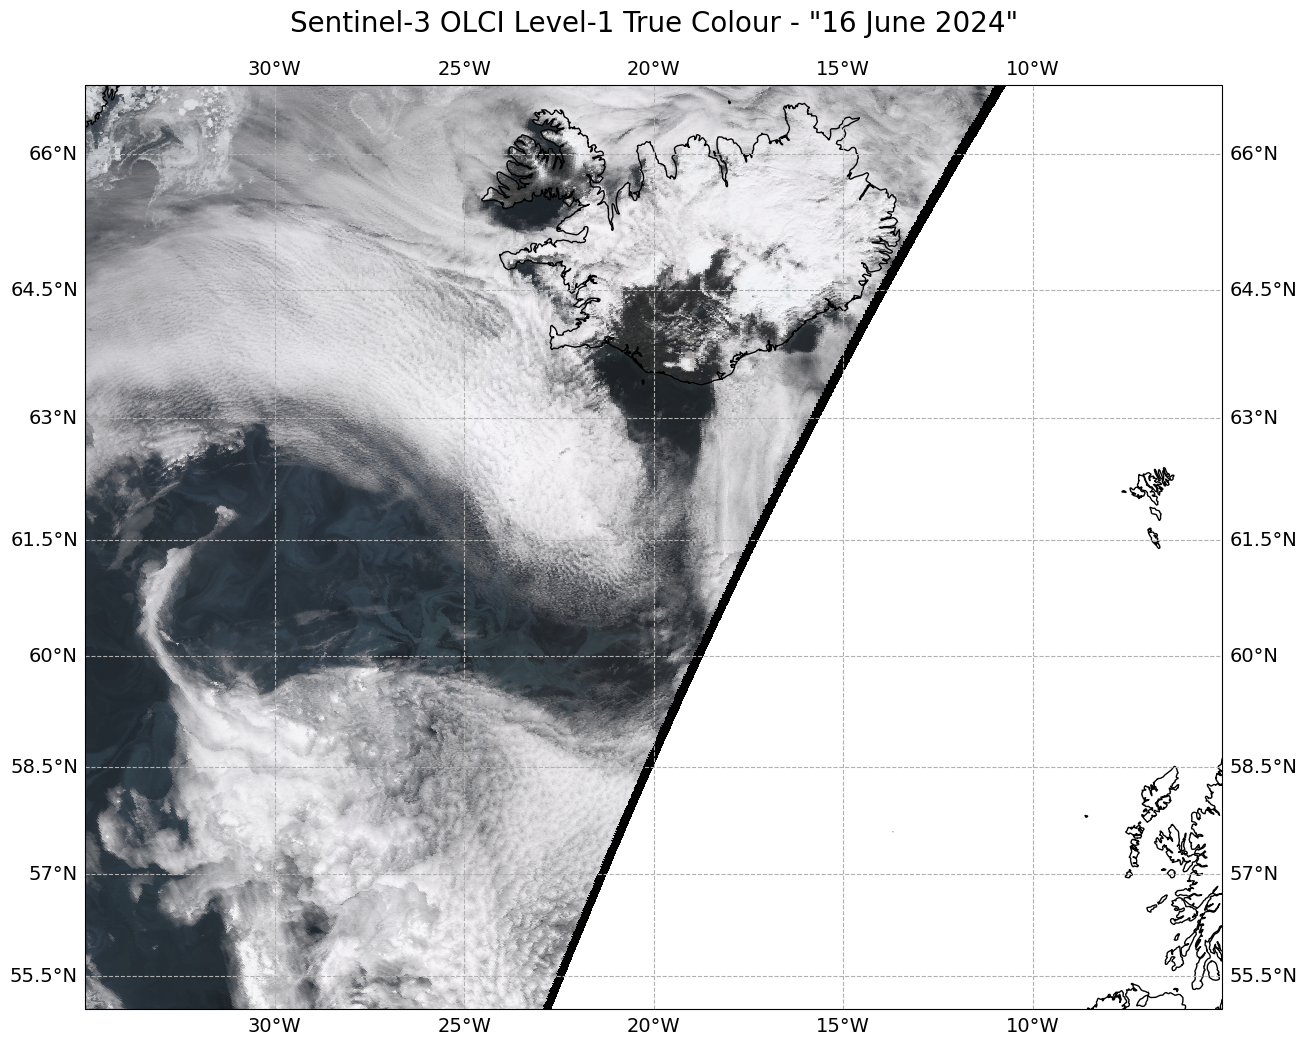

In [24]:
visualize_s3_pcolormesh(color_array=colorTuple,
                        array=red, 
                        latitude=lat, 
                        longitude=lon, 
                        title='Sentinel-3 OLCI Level-1 True Colour - "16 June 2024"')